<a href="https://colab.research.google.com/github/JongHyun2332/ipympl/blob/master/1001_%5BProject%5D_PCA_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA with Customer Segmentation

* [Reference](https://www.kaggle.com/asindico/customer-segments-with-pca)

* Reconstructed by JaeHong Jeong
>- 2021/10/01

* Objectives
>- 각기 다른 구매 패턴을 찾아 Customer Segmentation을 진행해보고자 한다.
>- I hope this information will be useful for the next prediction task. 

* 49,688 Products 
* 134 Aisles: represent categories of products.

* Before Clustering 
>- PCA so that clustering will be easier.
>- I will then try to find possible explanations for the identified clusters.

## 1. First Exploration

In [ ]:
import numpy as np 
import pandas as pd 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = './drive/MyDrive/# ML Project 시나브로/data'
orders = pd.read_csv(file_path + "/orders.csv")
prior = pd.read_csv(file_path + "/order_products__prior.csv")
train = pd.read_csv(file_path + "/order_products__train.csv")
products = pd.read_csv(file_path + "/products.csv")
aisles = pd.read_csv(file_path + "/aisles.csv")
departments = pd.read_csv(file_path + "/departments.csv")

In [ ]:
orders.head(20)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [ ]:
prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [ ]:
train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


### 1.1 Understanding of Data Structure
>- users are identified by user_id in the orders.csv. 
>- Each row of the orders.csv file represents an order made by a user. 
>- Orders are identified by order_id;

* Each order of a user is characterized by an ```order_number``` which specifies when it has been made with respect to the others of the same user

* Each order consists of a set of product each characterized by an ```add_to_cart_order``` feature representing the sequence in which they have been added to the cart in that order

* For each user we have ```n-1 prior orders and 1 train order``` 
* Or for each user, ```n-1 prior orders and 1 test order``` in which we have to state what products have been reordered.

In [ ]:
##Due to the number of rows I have to reduce the set of prior data to publish the kernel 
##comment this if you execute it on your local machine
# prior = prior[:300000]

### 1.2. prior.csv에 orders.csv의 order_id로 정보 merge하기 

In [ ]:
order_prior = pd.merge(prior, orders, on='order_id')
order_prior

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0
...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,25247,prior,24,2,6,21.0
32434485,3421083,11352,7,0,25247,prior,24,2,6,21.0
32434486,3421083,4600,8,0,25247,prior,24,2,6,21.0
32434487,3421083,24852,9,1,25247,prior,24,2,6,21.0


In [ ]:
order_prior = order_prior.sort_values(by=['user_id','order_id'])
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
4089398,431534,196,1,1,1,prior,5,4,15,28.0
4089399,431534,12427,2,1,1,prior,5,4,15,28.0
4089400,431534,10258,3,1,1,prior,5,4,15,28.0
4089401,431534,25133,4,1,1,prior,5,4,15,28.0
4089402,431534,10326,5,0,1,prior,5,4,15,28.0


### 1.3. prior.csv에 products, orders, aisles 정보 merge하기 

In [ ]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [ ]:
print(aisles.shape)

(134, 2)


In [ ]:
_mt = pd.merge(prior, products, on = ['product_id','product_id'])
_mt = pd.merge(_mt,orders,on=['order_id','order_id'])
mt = pd.merge(_mt,aisles,on=['aisle_id','aisle_id'])
mt.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs
5,537,33120,2,1,Organic Egg Whites,86,16,180135,prior,15,2,8,3.0,eggs
6,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.0,eggs
7,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.0,eggs
8,623,33120,1,1,Organic Egg Whites,86,16,37804,prior,63,3,12,3.0,eggs
9,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.0,eggs


* prior 데이터에 추가된 정보
>- product_id에 따른 product 정보
>- order_id에 따른 orders 정보
>- aisle_id에 따른 aisle 정보

In [ ]:
mt.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'user_id', 'eval_set',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'aisle'],
      dtype='object')

* train 데이터에 상위 10위 품목 
```
Banana                    472565
Bag of Organic Bananas    379450
Organic Strawberries      264683
Organic Baby Spinach      241921
Organic Hass Avocado      213584
Organic Avocado           176815
Large Lemon               152657
Strawberries              142951
Limes                     140627
Organic Whole Milk        137905
Name: product_name, dtype: int64
```

In [ ]:
mt['product_name'].value_counts()[0:10]

Banana                    472565
Bag of Organic Bananas    379450
Organic Strawberries      264683
Organic Baby Spinach      241921
Organic Hass Avocado      213584
Organic Avocado           176815
Large Lemon               152657
Strawberries              142951
Limes                     140627
Organic Whole Milk        137905
Name: product_name, dtype: int64

* train에서 한번이라도 구매한 상품은 49,677개였다.
>- 상품 총 49,688개 중 11개 제품을 제외한 모든 상품이 주문되었음을 확인할 수 있다.

In [ ]:
len(mt['product_name'].unique())

49677

In [ ]:
len(products['product_name'].unique())

49688

In [ ]:
prior.shape

(32434489, 4)

## 2. Clustering Customers
* 고객 분류하기

### 2.1. aisles 살펴보기
We are dealing with  134 types of product (aisle).

In [ ]:
len(mt['aisle'].unique())

134

In [ ]:
aisles

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


* train 데이터에 상위 10위 aisle (과일과 야채)
>- Fresh fruits and fresh vegetables are the best selling goods.
```
fresh fruits                     3642188
fresh vegetables                 3418021
packaged vegetables fruits       1765313
yogurt                           1452343
packaged cheese                   979763
milk                              891015
water seltzer sparkling water     841533
chips pretzels                    722470
soy lactosefree                   638253
bread                             584834
```

In [ ]:
mt['aisle'].value_counts()[0:10]

fresh fruits                     3642188
fresh vegetables                 3418021
packaged vegetables fruits       1765313
yogurt                           1452343
packaged cheese                   979763
milk                              891015
water seltzer sparkling water     841533
chips pretzels                    722470
soy lactosefree                   638253
bread                             584834
Name: aisle, dtype: int64

In [ ]:
# RAM 줄이기
del(prior)
del(train)
del(orders)
del(aisles)
del(products)
del(departments)

### 2.2. Customer Cluster
* 각기 다른 고객 중 clusters 를 찾기
* 해당 cluster를 대표하는 하나의 user_id로 대체하기
* 아이디어) 많은 user_id를 각각 분석하는 것보다, 구매 경향이 비슷한 cluster를 찾고 그들을 묶어 하나의 user_id로 대체해서 분석하는 것이 model performance를 향상시키고, 예측력을 높일 수 있지 않을까?



* Ths first thing to do is creating a dataframe with all the purchases made by each user
* pd.crosstab 은 교차표, 빈도수 확인가능

In [ ]:
mt

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,3243156,20731,1,0,Straight Sherry,134,5,166400,prior,3,1,13,12.0,specialty wines champagnes
32434485,860862,30582,1,0,Natural Champagne,134,5,104017,prior,13,5,14,18.0,specialty wines champagnes
32434486,1333472,27906,1,0,Imperial Champagne,134,5,62079,prior,10,3,10,10.0,specialty wines champagnes
32434487,2122701,26086,1,1,La Grand Dame Brut Champagne,134,5,77799,prior,2,3,14,3.0,specialty wines champagnes


In [ ]:
cust_prod = pd.crosstab(mt['user_id'], mt['aisle'])
cust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0,12,0,0,0,0,5,0,11,0,0,0,0,0,0,0,...,0,1,0,0,3,0,0,1,0,10,0,0,1,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,...,0,0,0,0,14,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,0,5,0,0,0,0,0,1,0,3,0,2,0,0,0,0,0,0,23,0,4,0,6,1,0,0,0,0,1,0,...,0,0,1,0,17,0,0,0,0,2,0,2,1,0,0,0,27,0,0,0,0,0,0,0,1,13,0,0,3,0,0,0,0,0,0,0,0,0,0,5
8,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,6,0,2,0,0,0,0,3,1,0,0,0,0,0,0,1,0,0,0,0,2,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,4,0,2,0,0,2,0,0,0,0,0,0,0,0,2,0,19


In [ ]:
cust_prod.shape

(206209, 134)

* RAM 줄이기

In [ ]:
del(mt)

In [ ]:
del(_mt)

### 2.3. PCA
* train데이터의 cust_prod 는 206,209명의 user가 134개 aisles제품군에 대한 주문이력이다.
* 134개의 aisles 제품군을 PCA로 6개까지 줄여보자.

We can then execute  a Principal Component Analysis to the obtained dataframe. This will reduce the number of features from the number of aisles to 6, the numbr of principal components I have chosen.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)


* PCA 후 206,209 user에 대해서 6개의 차원축소된 aisles columns만 남았다.

In [ ]:
ps = pd.DataFrame(pca_samples)
ps

,0,1,2,3,4,5
0,-24.215659,2.429427,-2.466370,-0.145700,0.268938,-1.432801
1,6.463208,36.751116,8.382554,15.097537,-6.920856,-0.978415
2,-7.990302,2.404383,-11.030065,0.672235,-0.442360,-2.823199
3,-27.991129,-0.755823,-1.921732,2.091887,-0.288227,0.926165
4,-19.896394,-2.637225,0.533229,3.679230,0.612830,-1.624001
...,...,...,...,...,...,...
206204,-24.200168,1.369802,1.325348,4.935903,0.318346,0.004865
206205,-4.837135,-0.152500,5.263275,-21.059413,0.728531,-13.416254
206206,8.611433,7.701299,7.952402,-5.906240,1.718252,-3.266540
206207,84.086220,20.418734,8.054106,-15.558561,9.035302,-37.417963


* I haven plotted several pair of components looking for the one suitable
* In my opinion,  for a KMeans Clustering.  I have chosen the (PC4,PC1) pair. 
* Since each component is the projection of all the points of the original dataset I think each component is representative of the dataset. 

(206209, 2)
          4          1
0  0.268938   2.429427
1 -6.920856  36.751116
2 -0.442360   2.404383
3 -0.288227  -0.755823
4  0.612830  -2.637225


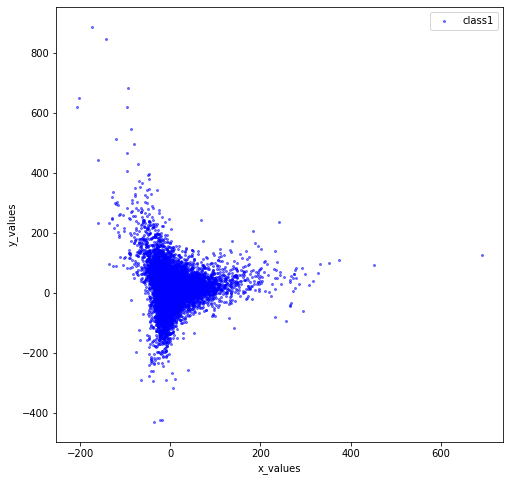

In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
tocluster = pd.DataFrame(ps[[4,1]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[4], tocluster[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[ -0.11794271   0.10272824]
 [ 76.84467052  26.26944397]
 [ -4.70354096 -40.54493812]
 [-11.27576869  65.27501086]]


In [ ]:
print (c_preds[0:100])

[0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 2 0 0 2 3 0 0 0 0 0 0 0 0 0 0]


### 2.4. Cluster
* Here is how our clusters appear

['orange', 'green', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


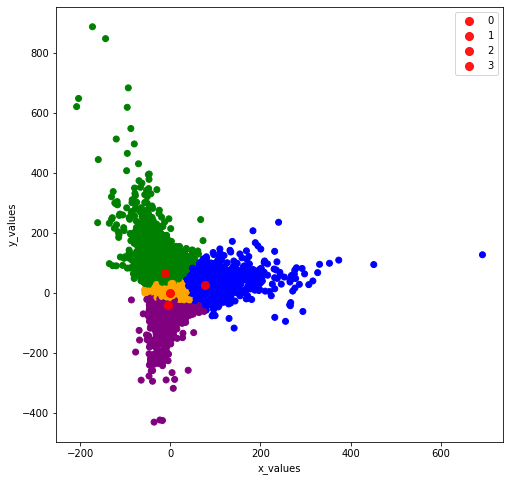

In [ ]:
import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[4],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [ ]:
import numpy as np

In [ ]:
for i in range(4):
  print(f"{i}번 cluster user수: {clust_prod[clust_prod['cluster']==i].shape[0]}명\t 비율: {np.round(clust_prod[clust_prod['cluster']==i].shape[0]/clust_prod.shape[0] * 100, 1)}%")
print('-'*35)
print(f"모든 total  user수: {clust_prod.shape[0]}명")

0번 cluster user수: 187259명	 비율: 90.8%
1번 cluster user수: 1843명	 비율: 0.9%
2번 cluster user수: 11171명	 비율: 5.4%
3번 cluster user수: 5936명	 비율: 2.9%
-----------------------------------
모든 total  user수: 206209명


* 기존의 user와 aisles 제품군을 cross table에서 6개 주성분으로 PCA로 차원축소하여, PC4, PC1으로 KMeans Clustering하여 4개의 Clusters로 분리하였다.  
>- clust_prod는 cust_prod에 clusters를 0부터 3까지 4개로 라벨링한 columns을 추가한 것이다.

In [ ]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

clust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,0,3,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0,12,0,0,0,0,5,0,11,0,0,0,0,0,0,0,...,1,0,0,3,0,0,1,0,10,0,0,1,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,1,0,0,0,0,2,0,42,3
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,...,0,0,0,14,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,4,1,0,0,0,0,0,2,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
5,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,0,5,0,0,0,0,0,1,0,3,0,2,0,0,0,0,0,0,23,0,4,0,6,1,0,0,0,0,1,0,...,0,1,0,17,0,0,0,0,2,0,2,1,0,0,0,27,0,0,0,0,0,0,0,1,13,0,0,3,0,0,0,0,0,0,0,0,0,0,5,0
8,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,6,0,2,0,0,0,0,3,1,0,0,0,0,0,0,1,0,0,0,0,2,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,4,0,2,0,0,2,0,0,0,0,0,0,0,0,2,0,19,0


* We have found a possible clustering for our customers.
>- Let's check if we also manage to find some interesting pattern beneath it.
* cluster별로 groupby 하여, 각 제품군 aisles를 평균적으로 얼마나 구입했는지 소비 패턴 추출하기

In [ ]:
# === Import Modules ===
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
color = sns.color_palette()

(206209, 135)


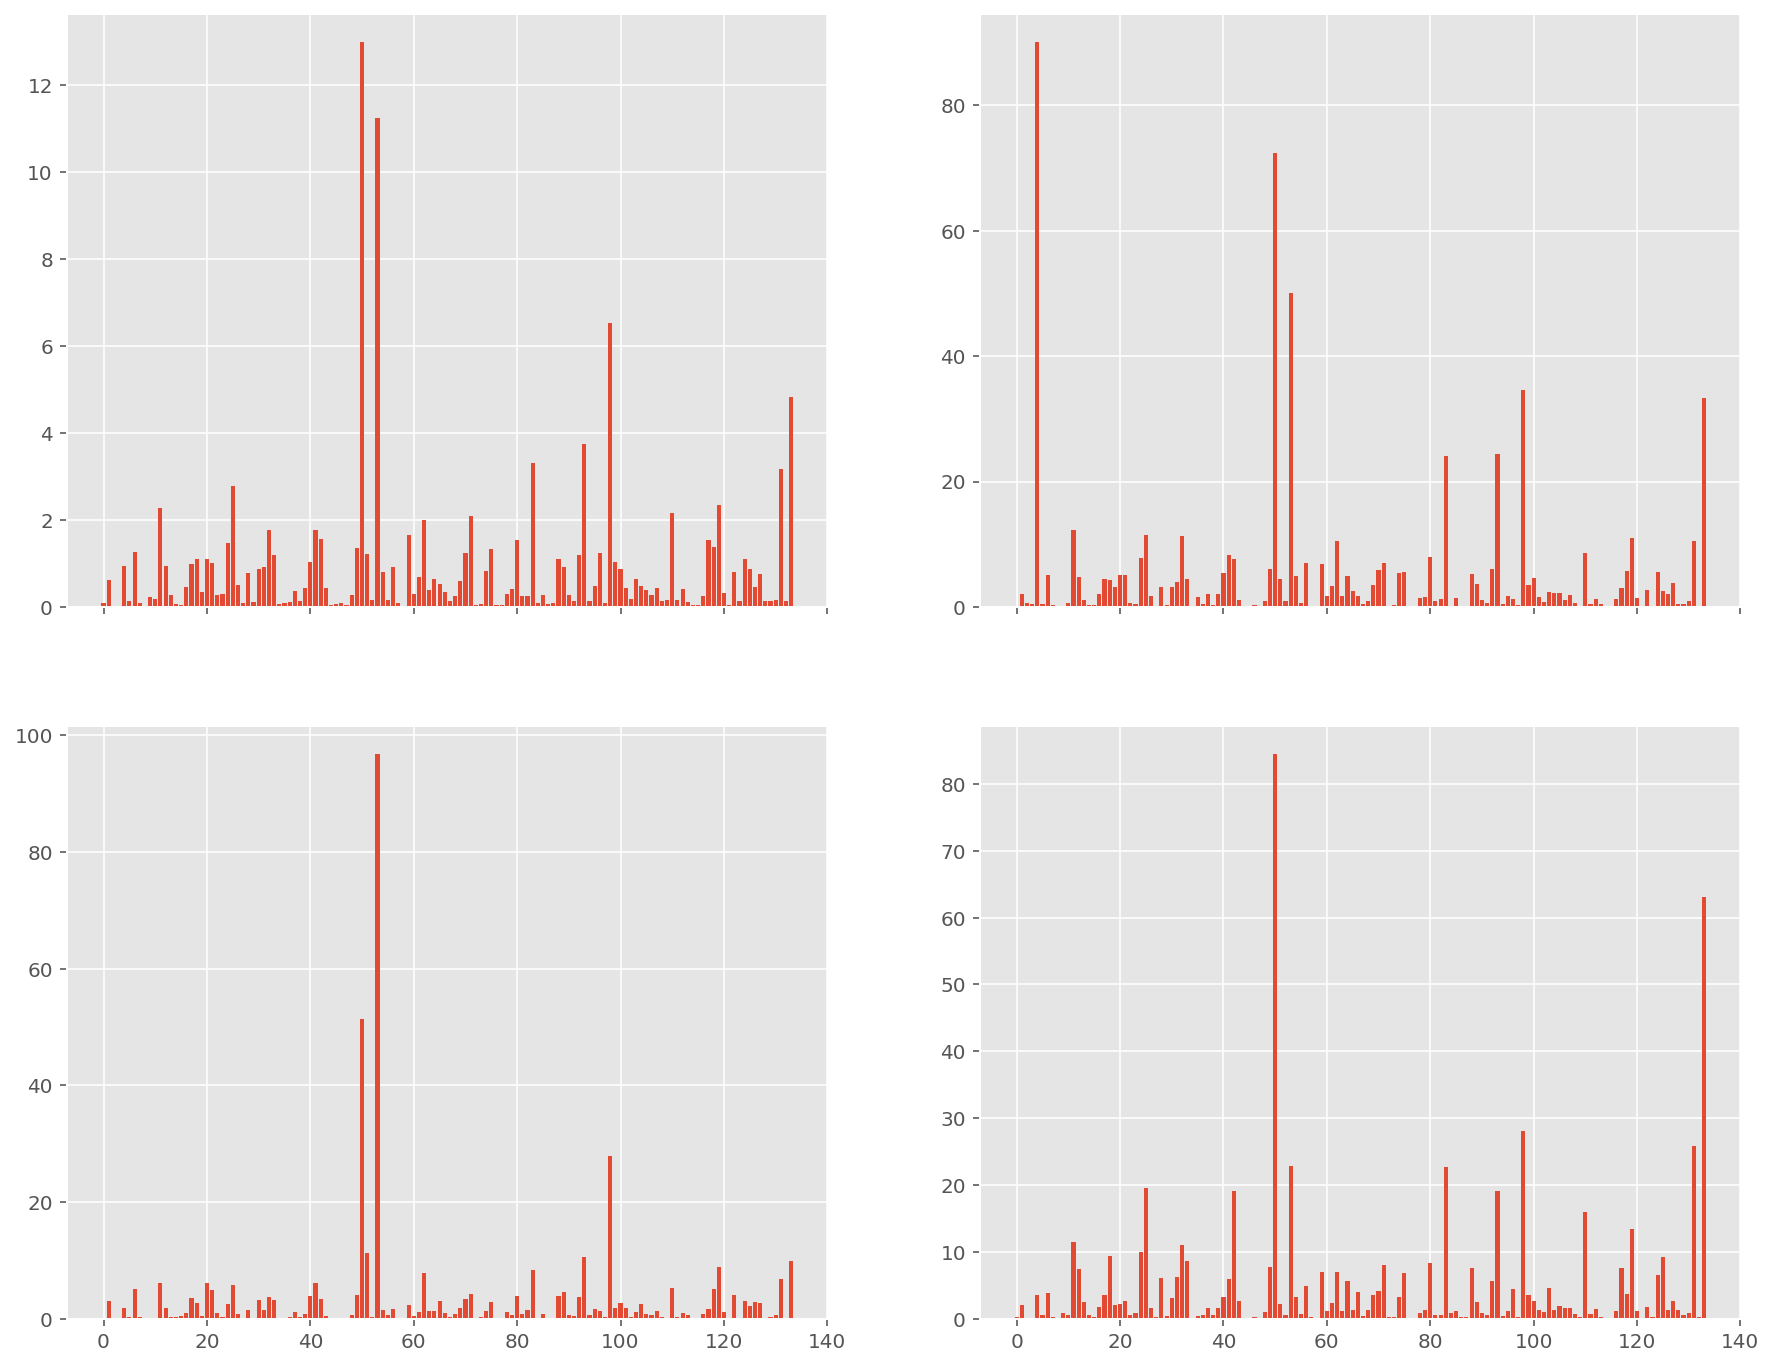

In [ ]:
print (clust_prod.shape)
plt.style.use('ggplot')

f,arr = plt.subplots(2,2,sharex=True,figsize=(15,12))

c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)), c0)
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)
c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)
plt.show()


### 2.5. Customer Segmentation 분석
* Let's check out what are the top 10 goods bought by people of each cluster.
* We are going to rely first on the absolute data and then on a percentage among the top 8 products for each cluster.

```
0번 cluster user수: 187259명	 비율: 90.8%
1번 cluster user수: 1843명	 비율: 0.9%
2번 cluster user수: 11171명	 비율: 5.4%
3번 cluster user수: 5936명	 비율: 2.9%
모든 total  user수: 206209명
```

* 고객유형A: 선선 과일 야채
>- fresh fruits, fresh vegetables 
>- 가장 약한 구매력
>- 일반적인 소비력 90.8%

In [ ]:
c0.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     12.994879
fresh vegetables                 11.257825
packaged vegetables fruits        6.531195
yogurt                            4.839655
packaged cheese                   3.754372
milk                              3.302912
water seltzer sparkling water     3.168702
chips pretzels                    2.782574
soy lactosefree                   2.349543
bread                             2.278710
dtype: float64

* 고객유형B: 가정주부
>- baby food formula, fresh fruits, fresh vegetables
>- 가장 왕성한 구매력을 갖고 있음
>- 0.9% 

In [ ]:
c1.sort_values(ascending=False)[0:10]

aisle
baby food formula             90.056430
fresh fruits                  72.362453
fresh vegetables              50.082474
packaged vegetables fruits    34.570266
yogurt                        33.253391
packaged cheese               24.314162
milk                          24.007596
bread                         12.206186
chips pretzels                11.463918
crackers                      11.253391
dtype: float64

* 고객유형C: 허브와 치즈러버
>- 세번째로 다음으로 강한 구매력
>- fresh vegetables, fresh fruits
>- packaged vegetables fruits 를 좋아한다.
>- 특이사항을 fresh herbs와 packaged cheese를 좋아한다.
>- 5.4%

In [ ]:
c2.sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 96.824993
fresh fruits                     51.364873
packaged vegetables fruits       27.885686
fresh herbs                      11.303912
packaged cheese                  10.637365
yogurt                            9.916570
soy lactosefree                   8.791156
milk                              8.350371
frozen produce                    7.802435
water seltzer sparkling water     6.771909
dtype: float64

* 고객유형D: 요거트와 탄산수 러버
>- fresh fruits
>- yogurt, water seltzr sparkling water를 좋아한다.
>- 2.9%를 차지

In [ ]:
c3.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     84.504549
yogurt                           63.007075
packaged vegetables fruits       28.144205
water seltzer sparkling water    25.794306
fresh vegetables                 22.903976
milk                             22.740398
chips pretzels                   19.468497
packaged cheese                  19.050202
energy granola bars              19.037567
refrigerated                     16.020553
dtype: float64

* 2.1. aisles 살펴보기 참고

* A first analysis of the clusters confirm the initial hypothesis that:
```
fresh fruits                     
fresh vegetables                 
packaged vegetables fruits       
yogurt                           
packaged cheese                   
milk                              
water seltzer sparkling water     
chips pretzels                    
```
are products which are genereically bought by the majority of the customers.

* 가장 많이 팔린 제품 리스트에 있는 제품으로 cluster를 특징짓기는 다소 어렵다. 다른 cluster와의 차이에 주목하여 특이사항을 살펴본후, 고객구매패턴을 구분하는 것이 바람직하다.

#### 2.5.1. 평균 구매치로 분석
* 각 Cluster 별 상위 8개 품목에 대한 평균 구매치를 살펴보자

In [ ]:
from IPython.display import display, HTML
cluster_means = [[c0['fresh fruits'],c0['fresh vegetables'],c0['packaged vegetables fruits'], c0['yogurt'], c0['packaged cheese'], c0['milk'],c0['water seltzer sparkling water'],c0['chips pretzels']],
                 [c1['fresh fruits'],c1['fresh vegetables'],c1['packaged vegetables fruits'], c1['yogurt'], c1['packaged cheese'], c1['milk'],c1['water seltzer sparkling water'],c1['chips pretzels']],
                 [c2['fresh fruits'],c2['fresh vegetables'],c2['packaged vegetables fruits'], c2['yogurt'], c2['packaged cheese'], c2['milk'],c2['water seltzer sparkling water'],c2['chips pretzels']],
                 [c3['fresh fruits'],c3['fresh vegetables'],c3['packaged vegetables fruits'], c3['yogurt'], c3['packaged cheese'], c3['milk'],c3['water seltzer sparkling water'],c3['chips pretzels']]]
cluster_means = pd.DataFrame(cluster_means, columns = ['fresh fruits','fresh vegetables','packaged vegetables fruits','yogurt','packaged cheese','milk','water seltzer sparkling water','chips pretzels'])
HTML(cluster_means.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,12.994879,11.257825,6.531195,4.839655,3.754372,3.302912,3.168702,2.782574
1,72.362453,50.082474,34.570266,33.253391,24.314162,24.007596,10.526858,11.463918
2,51.364873,96.824993,27.885686,9.916570,10.637365,8.350371,6.771909,5.793125
3,84.504549,22.903976,28.144205,63.007075,19.050202,22.740398,25.794306,19.468497


#### 2.5.2. percentage로 분석
* The following table depicts the percentage these goods with respect to the other top 8 in each cluster. It is easy some interesting differences among the clusters. 

* 고객유형B 가정주부(cluster 1) buy more fresh vegetables than the other clusters. As shown by absolute data, Cluster 1 is also the cluster including those customers buying far more goods than any others. (0.9%에 해당하는 인원이지만, 다른 고객유형에 비해 왕성한 구매력을 보인다.)

* 고객유형B 가정주부(cluster 1) buy a Lot of 'Baby Food Formula' which not even listed in the top 8 products but mainly characterize this cluster.
>- Coherently (I think) with this observation they buy more milk than the others. 우유를 더 많이 사갈 것이라고 예측할 수 있다.

* 고객유형D 요거트 탄산수 러버(cluster 3) buy more yogurt than people of the other clusters.



In [ ]:
cluster_perc = cluster_means.iloc[:, :].apply(lambda x: np.round((x / x.sum())*100, 1), axis=1)
HTML(cluster_perc.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,26.7,23.1,13.4,10.0,7.7,6.8,6.5,5.7
1,27.8,19.2,13.3,12.8,9.3,9.2,4.0,4.4
2,23.6,44.5,12.8,4.6,4.9,3.8,3.1,2.7
3,29.6,8.0,9.9,22.1,6.7,8.0,9.0,6.8


* Interesting information 
>- Cluster별 상위 10~ 15위 살펴보기

In [ ]:
c0.sort_values(ascending=False)[10:15]

aisle
refrigerated      2.168729
ice cream ice     2.082853
frozen produce    2.001527
eggs              1.777773
crackers          1.766115
dtype: float64

In [ ]:
c1.sort_values(ascending=False)[10:15]

aisle
soy lactosefree                  11.008139
frozen produce                   10.575692
water seltzer sparkling water    10.526858
refrigerated                      8.534997
eggs                              8.321215
dtype: float64

In [ ]:
c2.sort_values(ascending=False)[10:15]

aisle
eggs                        6.173664
canned jarred vegetables    6.091845
bread                       6.019425
chips pretzels              5.793125
refrigerated                5.276072
dtype: float64

In [ ]:
c3.sort_values(ascending=False)[10:15]

aisle
soy lactosefree    13.441038
bread              11.520553
crackers           11.001685
cereal              9.974057
candy chocolate     9.356806
dtype: float64

* As you can note by taking into account more products clusters start to differ significantly. I hope this informtion will be useful in the next prediction task.